In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, RepeatedKFold, GridSearchCV

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
#missing data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
MasVnrType,872,0.597260
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479


In [4]:
train = train.drop(labels=(missing_data[missing_data['Total'] > 1]).index, axis=1)
train = train.drop(labels=train.loc[train['Electrical'].isnull()].index)
test = test.drop(labels=(missing_data[missing_data['Total'] > 1]).index, axis=1)
test = test.drop(labels=test.loc[test['Electrical'].isnull()].index)

#outlier deletion
train = train.drop(train[train['Id'] == 1299].index)
train = train.drop(train[train['Id'] == 524].index)

C:\Users\inphi\AppData\Local\Temp\ipykernel_3428\907364868.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['SalePrice'], fit=norm);
c:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\inphi\AppData\Local\Temp\ipykernel_3428\907364868.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[6.75227038 7.14045304 6.82437367 ... 7.04925484 6.98286275 7.13568735]' has dtype incompatible with int64, please explicitly cast to a

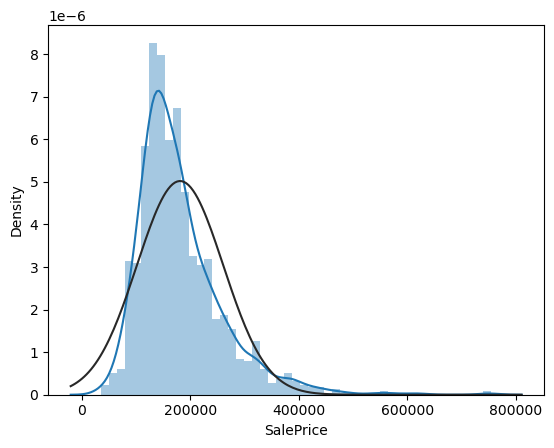

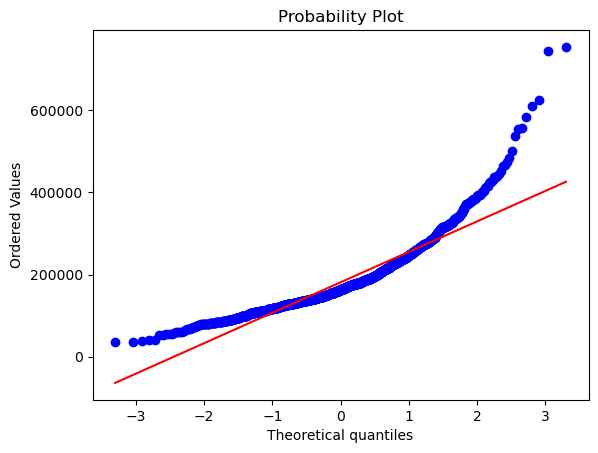

In [5]:
#applying log transformation
from scipy.stats import norm
from scipy import stats
sns.distplot(train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
train['SalePrice'] = np.log(train['SalePrice'])
train['GrLivArea'] = np.log(train['GrLivArea'])

#create dummy variable for basement, then log transform
train['HasBsmt'] = pd.Series(len(train['TotalBsmtSF']), index=train.index)
train['HasBsmt'] = 0 
train.loc[train['TotalBsmtSF']>0,'HasBsmt'] = 1
train.loc[train['HasBsmt']==1,'TotalBsmtSF'] = np.log(train['TotalBsmtSF'])

In [6]:
#drop Id
train = train.drop(columns = ['Id'])
#get dummy variables
train = pd.get_dummies(train)
test = pd.get_dummies(test)#not same as train
test = test.reindex(columns = train.columns, fill_value = 0)

#get column headers
yDescription = 'SalePrice'
ytrain = train[yDescription]
xtrain = train.drop(columns = [yDescription])
#second training set without 
xtrain_income = xtrain
xDescription = list(xtrain.columns)

In [7]:
# #scale
# from sklearn.preprocessing import StandardScaler
# class DummyScaler(StandardScaler):
#     def DummyFit(self, X):
#         try:
#             X = X.values
#         except:
#             pass
        
#         mean = []
#         std = []
#         for i in range(X.shape[1]):
#             x = X[:,i]
#             if len(np.unique(x)) > 2:
#                 mean.append(np.mean(x))
#                 std.append(np.std(x))
#             else: #dummy
#                 mean.append(0)
#                 std.append(1)
#         self.mean_ = np.array(mean)
#         self.scale_ = np.array(std)
#         self.var_ = np.array(std)**2
            
# xscaler = DummyScaler()
# xscaler.DummyFit(xtrain)
# xtrain = xscaler.transform(xtrain)


In [8]:
import lightgbm as lgb


lgbm_model = lgb.LGBMRegressor(random_state=42, n_jobs=-1)
lgbm_model.fit(xtrain, ytrain)
ypred = lgbm_model.predict(xtrain)
mae = mean_absolute_error(ytrain, ypred)
mse = mean_squared_error(ytrain, ypred)
r2 = r2_score(ytrain, ypred)

print(f'MAE: {mae:.3f}')
print(f'MSE: {mse:.3f}')
print(f'R2: {r2:.3f}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2999
[LightGBM] [Info] Number of data points in the train set: 1457, number of used features: 142
[LightGBM] [Info] Start training from score 12.024005
MAE: 0.030
MSE: 0.002
R2: 0.988


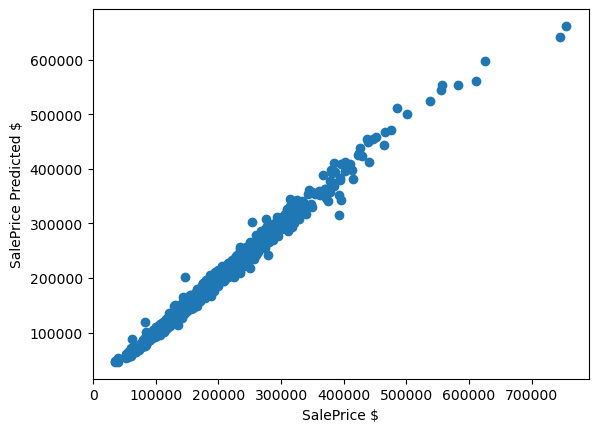

In [11]:
# unlog ypred and ytrain
ypred_unlog = np.exp(ypred)
ytrain_unlog = np.exp(ytrain)

#plot ypred vs ytrain
plt.scatter(ytrain_unlog, ypred_unlog)
plt.xlabel(f'{yDescription} $')
plt.ylabel(f'{yDescription} Predicted $')
plt.show()

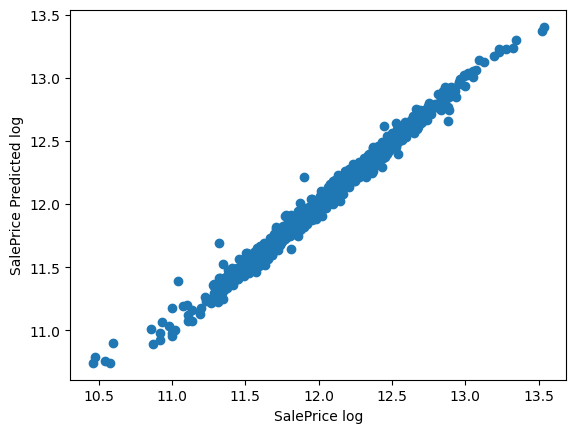

In [12]:
#plot ypred vs ytrain
plt.scatter(ytrain, ypred)
plt.xlabel(f'{yDescription} log')
plt.ylabel(f'{yDescription} Predicted log')
plt.show()